# Bayesian Robust Regression in PyMC3
An extension of a [blog post](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/) by [Thomas Wiecki](https://sites.google.com/a/brown.edu/lncc/home/members) in which degrees of freedom is estimated.

In [1]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

import theano

In [2]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

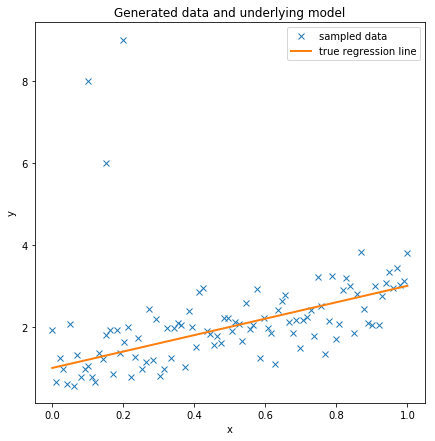

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

# Robust Regression

In [4]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, progressbar=False, njobs=8)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


         Current function value: 174.090856
         Iterations: 10
         Function evaluations: 92
         Gradient evaluations: 80


In [5]:
def plot_posterior_predictive(trace, eval=None, lm=None, samples=30, **kwargs):
    """Plot posterior predictive of a linear model.

    :Arguments:
        trace : <array>
            Array of posterior samples with columns
        eval : <array>
            Array over which to evaluate lm
        lm : function <default: linear function>
            Function mapping parameters at different points
            to their respective outputs.
            input: point, sample
            output: estimated value
        samples : int <default=30>
            How many posterior samples to draw.

    Additional keyword arguments are passed to pylab.plot().

    """
    import matplotlib.pyplot as plt

    if lm is None:
        lm = lambda x, sample: sample['Intercept'] + sample['x'] * x

    if eval is None:
        eval = np.linspace(0, 1, 100)

    # Set default plotting arguments
    if 'lw' not in kwargs and 'linewidth' not in kwargs:
        kwargs['lw'] = .2
    if 'c' not in kwargs and 'color' not in kwargs:
        kwargs['c'] = 'k'

    for rand_loc in np.random.randint(0, len(trace), samples):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), **kwargs)
        # Make sure to not plot label multiple times
        kwargs.pop('label', None)

    plt.title('Posterior predictive')

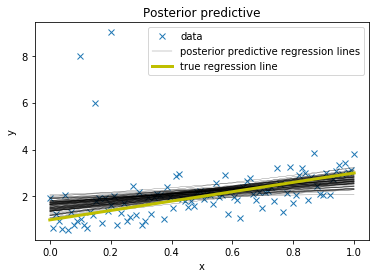

In [6]:
plt.subplot(111, xlabel='x', ylabel='y',
           title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data',)
plot_posterior_predictive(trace, samples=100,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')

plt.legend(loc=0);

In [7]:
# pm.traceplot(trace)

In [8]:
# pm.summary(trace)

In [9]:
# trace.varnames

In [10]:
# trace['x']

In [11]:
# pm.plots.autocorrplot(trace)

In [12]:
# accept = np.sum(trace['x'][1:] != trace['x'][:-1])
# print("Acceptance Rate: ", float(accept)/trace['x'].shape[0])

In [13]:
# score = pm.geweke(trace, first=0.1, last=0.5, intervals=20)
# score

In [14]:
# from IPython.core.pylabtools import figsize
# import matplotlib.cm as cm

In [15]:
# score=pm.geweke(trace, first=0.1, last=0.5, intervals=20)
# scores=list(x['x'] for x in score.values())
# chains=[x[0] for x in score.items()]
# figsize(14, 11)
# colors = iter(cm.rainbow(np.linspace(0, 1, len(scores))))
# for i, label in zip(range(len(scores)), chains):
#     sx = plt.subplot(len(scores)/2, 2, i+1)
#     plt.scatter(scores[i][:,0],scores[i][:,1], marker = 'o', s=100, label=label, color=next(colors))
#     plt.axhline(-1.98, c='gray')
#     plt.axhline(1.98, c='gray')
#     plt.ylim(-2.5,2.5)
#     plt.xlim(0-10,(trace['x'].shape[0]/2+10)/10)
#     plt.legend()
# plt.suptitle('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')

In [16]:
# pm.gelman_rubin(trace)

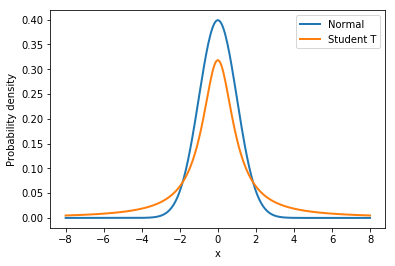

In [17]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

In [18]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_robust = pm.sample(2000, step, progressbar=False, njobs=8)

         Current function value: 123.926138
         Iterations: 13
         Function evaluations: 98
         Gradient evaluations: 86


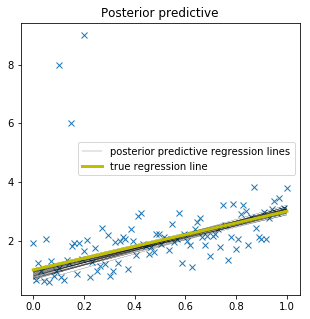

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive(trace_robust,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')
plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f748a4d8c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f746ef458d0>]], dtype=object)

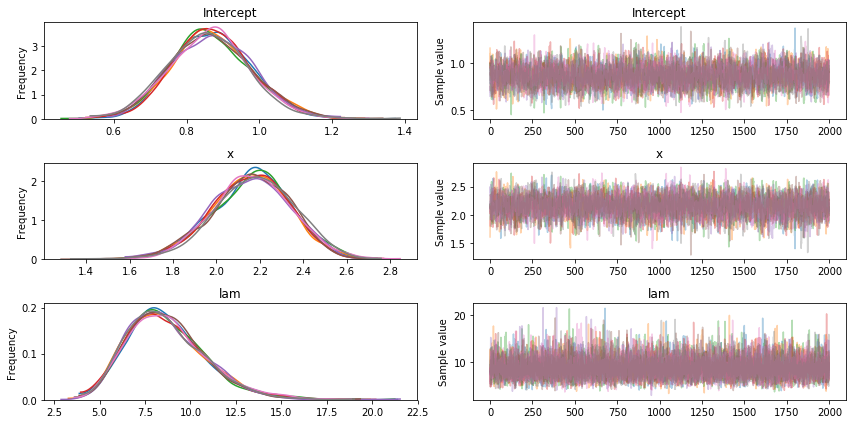

In [20]:
pm.traceplot(trace_robust)

## Extensions
How to use a prior for the degrees of freedom?

In [21]:
%load_ext rpy2.ipython

In [22]:
import warnings
warnings.filterwarnings('ignore')

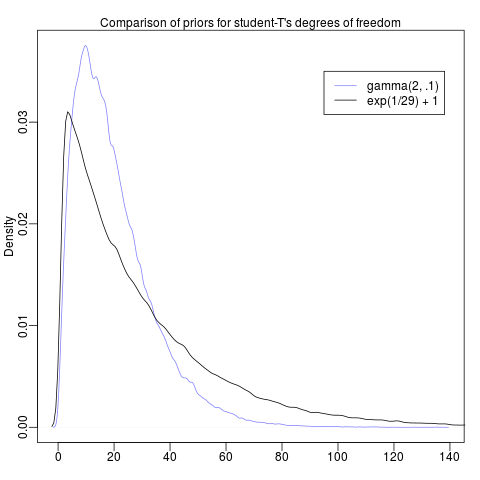

In [27]:
%%R require(rethinking)

N <- 1e5

# Juárezd and Steel via Aki Vehtari
gamma_prior <- rgamma(N, 2, 0.1)
# John Kruschke
exp_prior <- rexp(N, 1/29) + 1

dens(gamma_prior, col = rangi2, xlab = '')
dens(exp_prior, add = TRUE)
mtext("Comparison of priors for student-T\'s degrees of freedom")
legend(95, 0.035, c("gamma(2, .1)", "exp(1/29) + 1"), col = c(rangi2, 1), lty = 1)

In [24]:
with pm.Model() as model_robust:
    nu = pm.Gamma('nu', alpha=2, beta=0.1)  # Juárez and Steel prior
    # nu = pm.Exponential('nu', lam=1/29) + 1  # Kruschke prior
    family = pm.glm.families.StudentT(nu=nu)
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_robust = pm.sample(2000, step, progressbar=False, njobs=8)

         Current function value: 124.539842
         Iterations: 15
         Function evaluations: 117
         Gradient evaluations: 105


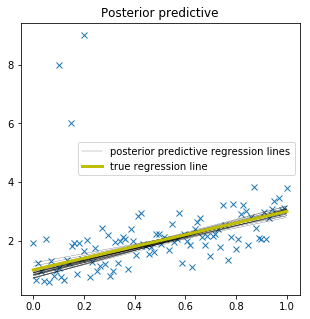

In [25]:
plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive(trace_robust,
                         label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
        label='true regression line', lw=3., c='y')
plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7444dbbf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7444775080>]], dtype=object)

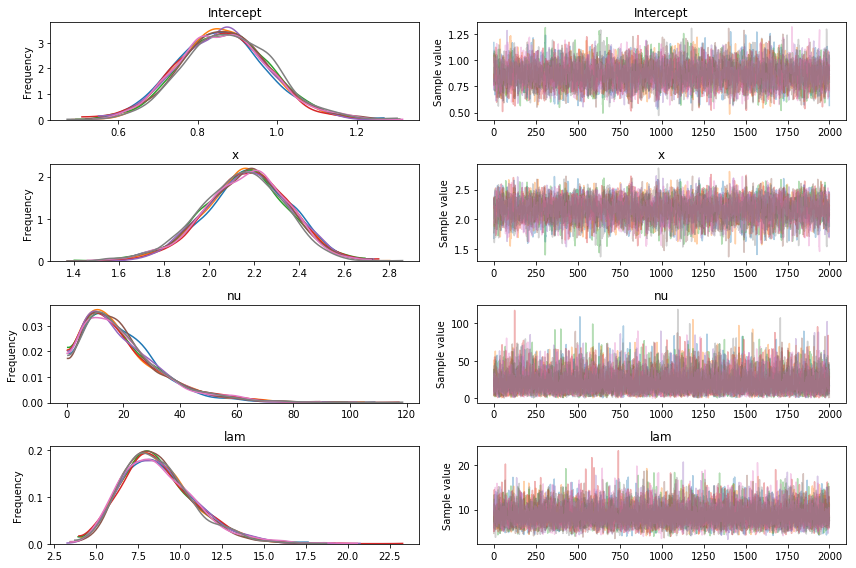

In [26]:
pm.traceplot(trace_robust)